<a href="https://colab.research.google.com/github/alexsalman/CSE247/blob/main/3D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow import keras

from PIL import Image

%matplotlib inline
 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
drive.mount('/content/gdrive/', force_remount=True)
gdrive_path = '/content/gdrive' + '/My Drive/247/'
os.chdir(gdrive_path)
print(os.getcwd())

Mounted at /content/gdrive/
/content/gdrive/My Drive/247


In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 16, 16
SEQUENCE_LENGTH = 16
DATASET_DIR = gdrive_path + 'Cropped_videos'
print(DATASET_DIR)
CLASSES_LIST = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

/content/gdrive/My Drive/247/Cropped_videos


In [5]:
# def frames_extraction(video_path):
#     '''
#     This function will extract the required frames from a video after resizing and normalizing them.
#     Args:
#         video_path: The path of the video in the disk, whose frames are to be extracted.
#     Returns:
#         frames_list: A list containing the resized and normalized frames of the video.
#     '''
 
#     # Declare a list to store video frames.
#     frames_list = []
    
#     # Read the Video File using the VideoCapture object.
#     video_reader = cv2.VideoCapture(video_path)
 
#     # Get the total number of frames in the video.
#     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
#     # Calculate the the interval after which frames will be added to the list.
#     skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
#     # Iterate through the Video Frames.
#     for frame_counter in range(SEQUENCE_LENGTH):
 
#         # Set the current frame position of the video.
#         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
#         # Reading the frame from the video. 
#         success, frame = video_reader.read() 
 
#         # Check if Video frame is not successfully read then break the loop
#         if not success:
#             break
 
#         # Resize the Frame to fixed height and width.
#         resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
#         # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
#         normalized_frame = resized_frame / 255
        
#         # Append the normalized frame into the frames list
#         frames_list.append(normalized_frame)
    
#     # Release the VideoCapture object. 
#     video_reader.release()
 
#     # Return the frames list.
#     return frames_list

In [6]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [7]:
def load_video(path, max_frames = 16, resize=(16, 16)):
    video_reader = cv2.VideoCapture(path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # print('video_frames_count before padding', video_frames_count)
    frames = []
    try:
        while True:
            ret, frame = video_reader.read()
            if not ret:
                  break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            black_frame = frame
            frames.append(frame)
        # if len(frames) < max_frames:
        #     try:
        #         what_day = int(path.split(' ')[2].split('_')[0])
        #     except:
        #         print('DS: ', path)
        #     num_of_right_frames = max_frames - what_day - 1
        #     num_of_left_frames = max_frames - num_of_right_frames - len(frames)

        #     if num_of_left_frames > 0:
        #         for _ in range(num_of_left_frames):
        #             frames.insert(0, black_frame)
        #         # print('video_frames_count after left padding', len(frames))
        #     elif num_of_right_frames > 0:
        #         for _ in range(num_of_right_frames):
        #             frames.append(black_frame)
        #         # print('video_frames_count after right padding', len(frames))
        
    finally:
        video_reader.release()
    return np.array(frames) / 255.0


In [8]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = load_video(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 


            # Extract the frames of the video file.
            # frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
# to be removed
            # if len(frames) == SEQUENCE_LENGTH:
 
            #     # Append the data to their repective lists.
            #     features.append(frames)
            #     labels.append(class_index)
            #     video_files_paths.append(video_file_path)
            # # left and right padding
            # ###################################################################
            # elif len(frames) > 0:
            #     black_frame = np.copy(frames[0])
            #     # print(frames[0].shape)
            #     # print(video_file_path)
            #     #### color change ############################################
            #     ############################################
            #     r1, g1, b1 = 0, 0, 0 # Original value
            #     r2, g2, b2 = 0, 0, 0 # Value that we want to replace it with

            #     red, green, blue = black_frame[:,:,0], black_frame[:,:,1], black_frame[:,:,2]
            #     mask = (red == r1) & (green == g1) & (blue == b1)
            #     black_frame[:,:,:3][mask] = [r2, g2, b2]
            #     ############################################
            #     ############################################
            #     # print("black frame: ", black_frame)
            #     what_day = int(video_file_path.split(' ')[2].split('_')[0])
            #     num_of_right_frames = SEQUENCE_LENGTH - what_day - 1
            #     num_of_left_frames = SEQUENCE_LENGTH - num_of_right_frames - len(frames)
            #     # print('right and left: ', num_of_right_frames, num_of_left_frames)
            #     padded_frames = []
            #     if num_of_left_frames > 0:
            #         for _ in range(num_of_left_frames):
            #             padded_frames.append(black_frame)
            #         # print('frames added in left for loop: ', len(padded_frames))
            #         padded_frames.append(frames)
            #         # print('padded_frames after left: ', len(padded_frames))
            #     else:
            #         padded_frames = frames

            #     if num_of_right_frames > 0:
            #         # print('just in right',len(padded_frames))
            #         for _ in range(num_of_right_frames):
            #             padded_frames.append(black_frame)
            #             # print('hello, append happend')
            #             # print(len(padded_frames))
            #     # print('Frames after padding: ', len(padded_frames))
            #     # Append the data to their repective lists.
            #     # if len(padded_frames) == SEQUENCE_LENGTH:
            #     features.append(padded_frames)
            #     labels.append(class_index)
            # #     video_files_paths.append(video_file_path)
            ##################################################################

    # Converting the list to numpy arrays
    features = np.asarray(features)
    # print(features)
    labels = np.array(labels)

    # targets_train = to_categorical(targets_train).astype(np.integer)
    # targets_test = to_categorical(targets_test).astype(np.integer)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [9]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: hemostasis
Extracting Data of Class: inflammatory
Extracting Data of Class: proliferative
Extracting Data of Class: maturation


In [10]:
one_hot_encoded_labels = to_categorical(labels)

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

####3DCNN

In [12]:
## input layer
input_layer = keras.layers.Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = keras.layers.Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = keras.layers.MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = keras.layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = keras.layers.MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = keras.layers.BatchNormalization()(pooling_layer2)
flatten_layer = keras.layers.Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = keras.layers.Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = keras.layers.Dropout(0.4)(dense_layer1)
dense_layer2 = keras.layers.Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = keras.layers.Dropout(0.4)(dense_layer2)
output_layer = keras.layers.Dense(units=4, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 16, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 14, 14, 14, 8)     656       
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 12, 12, 16)    3472      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 6, 6, 16)      0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 4, 4, 32)       13856     
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 2, 2, 64)       55360     
                                                             

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(learning_rate=0.1), metrics=['accuracy'])
cnn_3d_model_training_history = model.fit(x=features, y=one_hot_encoded_labels, batch_size=16, epochs=50, validation_split=0.2)

Epoch 1/50
108/108 [==============================] - 3s 9ms/step - loss: 0.9054 - accuracy: 0.5862 - val_loss: 1.1538 - val_accuracy: 0.0718
Epoch 2/50
108/108 [==============================] - 1s 6ms/step - loss: 0.7066 - accuracy: 0.6811 - val_loss: 1.2631 - val_accuracy: 0.0394
Epoch 3/50
108/108 [==============================] - 1s 6ms/step - loss: 0.6157 - accuracy: 0.7350 - val_loss: 1.0078 - val_accuracy: 0.4931
Epoch 4/50
108/108 [==============================] - 1s 6ms/step - loss: 0.5487 - accuracy: 0.7691 - val_loss: 0.9305 - val_accuracy: 0.4468
Epoch 5/50
108/108 [==============================] - 1s 6ms/step - loss: 0.5096 - accuracy: 0.7760 - val_loss: 1.1501 - val_accuracy: 0.4583
Epoch 6/50
108/108 [==============================] - 1s 6ms/step - loss: 0.4746 - accuracy: 0.7917 - val_loss: 1.1312 - val_accuracy: 0.5417
Epoch 7/50
108/108 [==============================] - 1s 6ms/step - loss: 0.4380 - accuracy: 0.8119 - val_loss: 0.5246 - val_accuracy: 0.7662
Epoch 

In [14]:
model_evaluation_history = model.evaluate(features_test, labels_test)

17/17 [==============================] - 0s 5ms/step - loss: 0.1921 - accuracy: 0.9519


In [15]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
model.save(model_file_name)

In [16]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

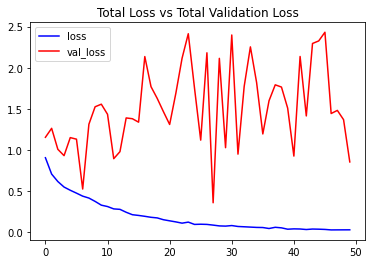

In [17]:
plot_metric(cnn_3d_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

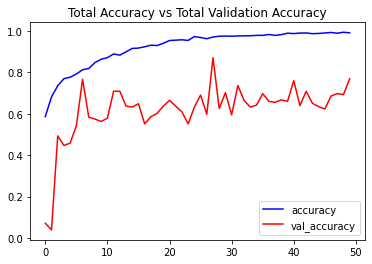

In [18]:
plot_metric(cnn_3d_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 